In [357]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor

from bayesopt.bayesopt import optimize_var_1D
from nn_integration.nni import integrate_ND_1L

## Define function and its gradient. Function will then be restored from its gradient

In [358]:
def func(x):
    return np.cos(2*x)

def grad_func(x,noise):
    return -2*np.sin(2*x) + noise*np.random.randn(*x.shape)

## Parameters to play with

In [359]:
X_bounds = np.array([[0.0], [np.pi/2]])

noise = 0.1

num_init_points = 4
num_gridpoints = 101

# ----- BayesOpt parameters ----- #
kernel = RBF(length_scale=1.0)
num_restarts = 100
max_iterations = 10
max_std_err = 1e-3

# ----- NN parameters ----- #
activation_function = "tanh"
solver = "lbfgs"
layer_size = 500
training_set_size = 500
max_iter = 200

In [360]:
grid = np.linspace(X_bounds[0],X_bounds[1],num_gridpoints).reshape(-1)

## Use Bayesian Optimization to learn the gradient function from a few noisy points

In [361]:
X_init = np.random.uniform(X_bounds[0],X_bounds[1],num_init_points).reshape(-1,1)
Y_init = grad_func(X_init,noise).reshape(-1,1)

In [362]:
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=num_restarts,alpha=noise**2)

In [363]:
means_iter, stds_iter = optimize_var_1D(X_init,Y_init,gpr,grad_func,grid.reshape(-1,1),max_iters=max_iterations,rel_std_noise=max_std_err)

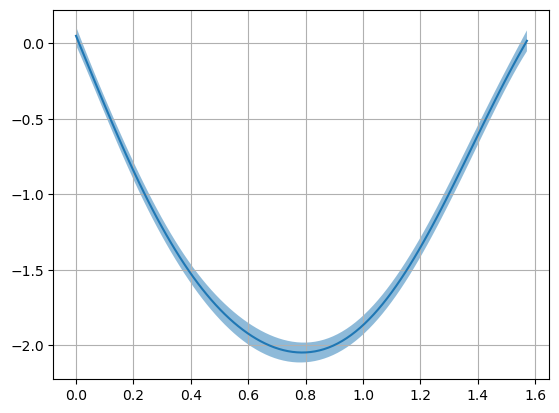

In [364]:
means = np.array(means_iter[-1])

plt.plot(grid,means)
plt.fill_between(grid,means-stds_iter[-1],means+stds_iter[-1],alpha=0.5)
plt.grid()

## Training the Neural Network on the output of the BayesOpt

In [365]:
rng = np.random.default_rng()
dataset = np.stack((grid,means_iter[-1]),axis=1)
training_data = rng.permutation(dataset,axis=0)[:training_set_size]

In [366]:
model = MLPRegressor((layer_size,),activation=activation_function,solver=solver,max_iter=max_iter)
model.fit(training_data[:,0].reshape(-1,1),training_data[:,1])
prediction = model.predict(grid.reshape(-1,1)).reshape(-1)

coefs = model.coefs_
biases = model.intercepts_

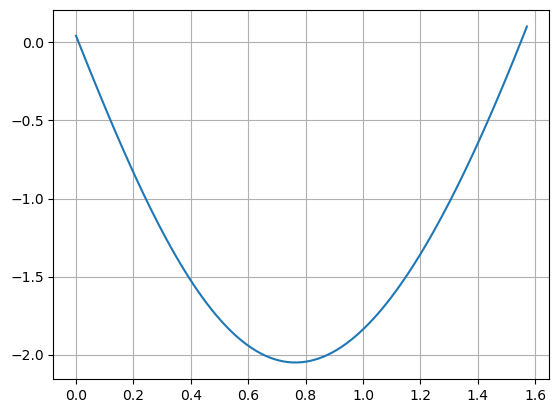

In [367]:
plt.plot(grid,prediction)
plt.grid()

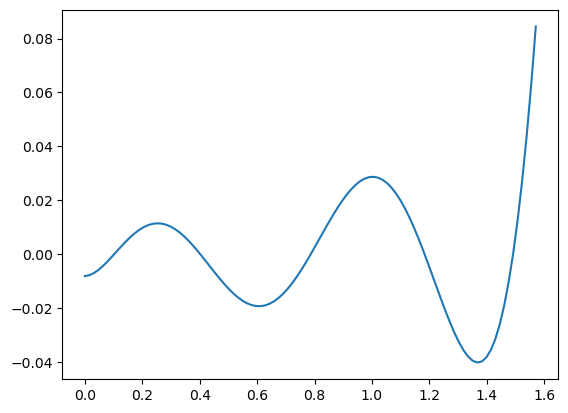

In [368]:
plt.plot(grid,prediction-means)

## Integrating the Network to restore the original function

In [369]:
bounds = np.array([[0],[np.pi/2]])

integral_mean = integrate_ND_1L(bounds,coefs,biases,activation_function)
print(f"mean: {integral_mean}")

mean: -2.0453465009972898


In [370]:
# Diagonal integral only works when grid is square
integral = np.zeros_like(grid)

for i,x in enumerate(grid[1:]):
    bounds = np.array([[0],[x]])
    integral[i+1] = integrate_ND_1L(bounds,coefs,biases,activation_function)

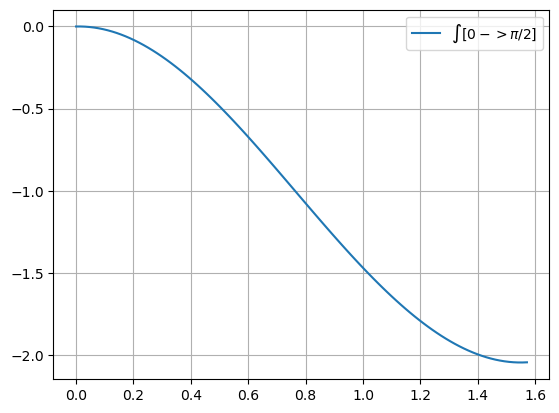

In [371]:
plt.plot(grid,integral,label="$\int[0->\pi/2]$")
plt.legend()
plt.grid()